# Cokriging from maximum likelihood estimates over continental US

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.insert(0, "../src")

In [3]:
import numpy as np
import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import krige_tools
import fields
import variogram as vgm
import cov_model
import cokrige

In [4]:
# Analysis variables
timestamp = "2019-08-01"
timedelta = -1

# Variogram settings
# bin_centers = np.linspace(0, 6e3, 20)
# tol = 250
n_bins = 15

# Initial guess for covariance params
covariograms = True

normalized = False
cov_guess = [0.5, 0.3, 1.5e4, 0.1]
cross_guess = [0.3, 1e4, -0.8]

# normalized = True
# cov_guess = [0.3, 1.5e4]
# cross_guess = [0.3, 1e4, -0.8]

In [5]:
# Get data: 5-degree monthly average, cont. US
ds = xr.open_dataset("../data/exp_pro/OCO2_4x5deg_monthly_conus.nc")

# Format as multi-fields
ds_xco2 = ds[["xco2", "xco2_var"]]
ds_sif = ds[["sif", "sif_var"]]

# Todo: make keywords a dict
mf = fields.MultiField(ds_xco2, ds_sif, timestamp, timedelta=timedelta, full_detrend=True, standardize_window=True, fast_dist=True)

/home/jj829/sif-data-fusion/conda-env/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/home/jj829/sif-data-fusion/conda-env/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


/home/jj829/sif-data-fusion/conda-env/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '


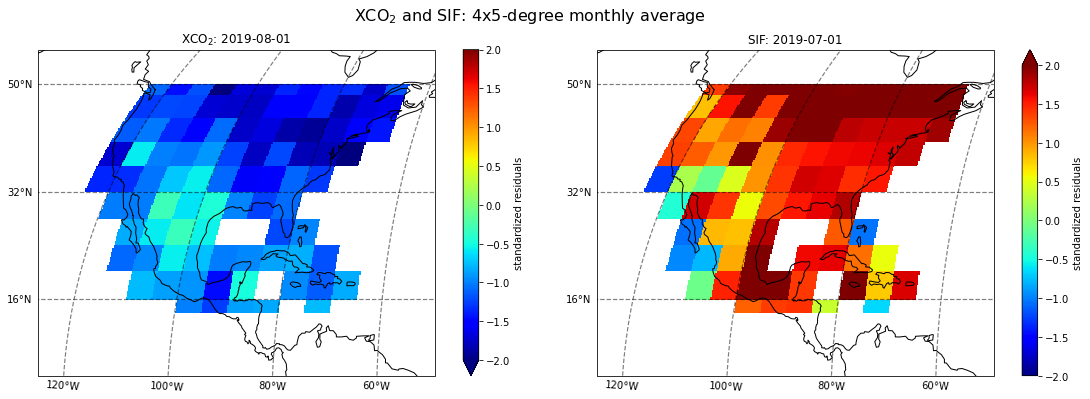

In [41]:
# Plot the data being used for cokriging
# NOTE: figures should share a color bar, but we just want a quick look
fig = plt.figure(figsize=(20, 6))
gs = fig.add_gridspec(100, 100)
# cbar_ax = fig.add_subplot(gs[:, 98:])
extents = [-125, -60, 5, 52]

fig.suptitle(
    "XCO$_2$ and SIF: 4x5-degree monthly average", 
    size=16, y=0.98
)

# Input data
ax1 = fig.add_subplot(gs[:, 0:50], projection=ccrs.EqualEarth())
ax2 = fig.add_subplot(gs[:, 50:], projection=ccrs.EqualEarth())

xr.plot.imshow(
        darray=mf.field_1.to_xarray()["values"].T,
        transform=ccrs.PlateCarree(),
        ax=ax1,
        cmap="jet",
        vmin=-2,
        center=0,
#         cbar_ax=None,
        cbar_kwargs={"label": "standardized residuals"},
    )
ax1.coastlines()
ax1.set_extent(extents)
ax1.set_title(f"XCO$_2$: {mf.field_1.timestamp}")
gl1 = ax1.gridlines(crs=ccrs.PlateCarree(), linewidth=1.2, color='black', alpha=0.5, linestyle='--', draw_labels=True)
gl1.top_labels = False
gl1.left_labels = True
gl1.right_labels = False
gl1.xlines = True
gl1.ylines = True
gl1.xlocator = mticker.FixedLocator([-120, -100, -80, -60])
gl1.ylocator = mticker.FixedLocator([16, 32, 50])
gl1.xformatter = LONGITUDE_FORMATTER
gl1.yformatter = LATITUDE_FORMATTER

xr.plot.imshow(
        darray=mf.field_2.to_xarray()["values"].T,
        transform=ccrs.PlateCarree(),
        ax=ax2,
        cmap="jet",
        vmin=-2,
        center=0,
#         cbar_ax=cbar_ax,
        cbar_kwargs={"label": "standardized residuals"},
    )
ax2.coastlines()
ax2.set_extent(extents)
ax2.set_title(f"SIF: {mf.field_2.timestamp}")
gl2 = ax2.gridlines(crs=ccrs.PlateCarree(), linewidth=1.2, color='black', alpha=0.5, linestyle='--', draw_labels=True)
gl2.top_labels = False
gl2.left_labels = True
gl2.right_labels = False
gl2.xlines = True
gl2.ylines = True
gl2.xlocator = mticker.FixedLocator([-120, -100, -80, -60])
gl2.ylocator = mticker.FixedLocator([16, 32, 50])
gl2.xformatter = LONGITUDE_FORMATTER
gl2.yformatter = LATITUDE_FORMATTER

fig.savefig("../plots/standardized_residuals_conus_45.png");

In [12]:
k1 = cov_model.Matern()
k2 = cov_model.Matern()
model = cov_model.BivariateMatern(mf, k1, k2)
vario_res, params = model.empirical_variograms(cov_guess, cross_guess, n_bins=n_bins, shift_coords=True, covariograms=covariograms, normalize_cov=normalized)
# predictor = cokrige.Cokrige(mf, model, fast_dist=True)

In [12]:
params

{'xco2': array([3.05936785e-01, 3.46426342e+04]),
 'sif': array([2.24377763e-01, 7.73372956e+03]),
 'xco2:sif': array([ 4.00000000e-01,  9.99999514e+03, -7.37386855e-01])}

In [13]:
names = [mf.field_1.data_name, "", mf.field_2.data_name]
names[1] = f"{names[0]}:{names[2]}"

guess = np.hstack([params[name] for name in names])
guess

array([ 3.05936785e-01,  3.46426342e+04,  4.00000000e-01,  9.99999514e+03,
       -7.37386855e-01,  2.24377763e-01,  7.73372956e+03])

In [13]:
# guess = list(model.get_params().values())
# guess[3] = 1600.0
# guess[4] = -0.7
# guess = [2.2, 1700.0, 0.1, 500.0, -0.6, 0.4, 1200.0, 0.1]
model.fit(initial_guess=guess)

print(model.get_params())
mle_params = list(model.get_params().values())
mle_params

In [15]:
vario_res["xco2"]["mle_fit"] = vgm.matern_cov(vario_res["xco2"]["lag"], *mle_params[:4])
vario_res["xco2:sif"]["mle_fit"] = vgm.matern_cross_cov(vario_res["xco2:sif"]["lag"], [mle_params[0], mle_params[7]], *mle_params[4:7])
vario_res["sif"]["mle_fit"] = vgm.matern_cov(vario_res["sif"]["lag"], *mle_params[7:])

In [15]:
def param_labels(params, normalized=False, cross=False):
    p = np.round_(params, decimals=3)
    if cross:
        return f"nu: {p[0]}\nlen_scale: {p[1]}\nrho: {p[2]}"
    elif normalized:
        return f"nu: {p[0]}\nlen_scale: {p[1]}"
    else:
        return f"sigma: {p[0]}\n nu: {p[1]}\n len_scale: {p[2]}\n nugget: {p[3]}"

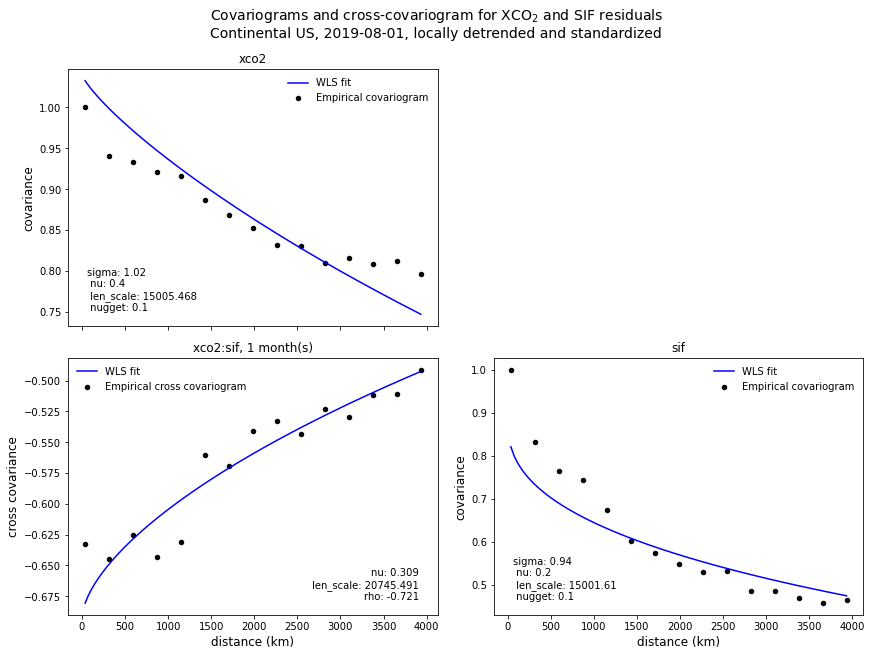

In [16]:
var_names = ["xco2", "sif"]
cross_name = "xco2:sif"

fig, ax = plt.subplots(2, 2, figsize=(12, 9), constrained_layout=True, sharex=True)
ax[0, 1].axis("off")
            
for i, var in enumerate(var_names):
    df = vario_res[var]
    df.plot(x="lag", y=var, kind="scatter", color="black", ax=ax[i, i], label="Empirical covariogram")
    df.dropna(subset=["wls_fit"]).sort_values("lag").plot(x="lag", y="wls_fit", kind="line", color="blue", ax=ax[i, i], label="WLS fit")
#     df.sort_values("lag").plot(x="lag", y="mle_fit", kind="line", color="red", ax=ax[i, i], label="ML fit")
    ax[i, i].set_title(var, fontsize=12)
    ax[i, i].set_ylabel("covariance", fontsize=12)
    ax[i, i].set_xlabel("distance (km)", fontsize=12)
    ax[i, i].text(0.05, 0.05, param_labels(params[var], normalized=normalized), transform=ax[i, i].transAxes, ha="left", va="bottom")
    ax[i, i].legend(frameon=False)

df = vario_res[cross_name]
df.plot(x="lag", y="xco2:sif", kind="scatter", color="black", ax=ax[1, 0], label="Empirical cross covariogram")
df.dropna(subset=["wls_fit"]).sort_values("lag").plot(x="lag", y="wls_fit", kind="line", color="blue", ax=ax[1, 0], label="WLS fit")
ax[1, 0].set_title(cross_name + f", {np.abs(timedelta)} month(s)", fontsize=12)

# df.sort_values("lag").plot(x="lag", y="mle_fit", kind="line", color="red", ax=ax[1, 0], label="ML fit")
ax[1, 0].text(0.95, 0.05, param_labels(params[cross_name], cross=True), transform=ax[1, 0].transAxes, ha="right", va="bottom")
ax[1, 0].legend(loc="upper left", frameon=False)

ax[1, 0].set_ylabel("cross covariance", fontsize=12)
ax[1, 0].set_xlabel("distance (km)", fontsize=12)

if normalized:
    fig.suptitle("Correlogram and cross-correlogram for XCO$_2$ and SIF residuals\n"+
                 f"Continental US, {timestamp}, locally detrended and standardized", fontsize=14)
#     fig.savefig(f"../plots/correlograms_conus45_{timestamp}_{np.abs(timedelta)}M.png", dpi=100);
else:
    fig.suptitle("Covariograms and cross-covariogram for XCO$_2$ and SIF residuals\n"+
                 f"Continental US, {timestamp}, locally detrended and standardized", fontsize=14)
#     fig.savefig(f"../plots/covariograms_conus45_{timestamp}_{np.abs(timedelta)}M.png", dpi=100);

With or without the addition of the measurement error along the covariance matrix diagional, MLE wants to push up sigma_11 and drive down sigma_22. This makes it hard to get good estimates for any other parameters and yeilds a very poor cross-covariance model (with respect to the empirical cross covariogram).